# Load packages

In [30]:
import pandas as pd
import numpy as np 
import os
from pprint import pprint
import matplotlib.pyplot as plt
import copy


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

os.chdir(r'C:\Users\mkommaraju\OneDrive - PayPal\MyDocuments_from_Laptop\Work\ML\NLP_Showcase')
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Load data

In [31]:
df_train_validate = pd.read_csv('train.csv')
df_test           = pd.read_csv('test.csv')

#df_train_validate = df_train_validate.loc[:1000]
#df_test = df_test.loc[:1000]

df_train_validate.columns
df_train_validate['ABSTRACT'].head()

from sklearn.model_selection import train_test_split
df_train, df_validate = train_test_split(df_train_validate, test_size = 0.2)

df_train.reset_index(inplace=True)
df_validate.reset_index(inplace=True)
df_test.reset_index(inplace=True)

X_train = df_train['ABSTRACT']
Y_train = df_train[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

X_validate = df_validate['ABSTRACT']
Y_validate = df_validate[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

X_test = df_test['ABSTRACT']


# Pre-process text

In [32]:
import custom_preprocessing as cp
def my_custom_preprocessing(texts):
    texts= cp.my_simple_preprocessing(texts)
    texts = [w for w in cp.sent_to_words(texts)] 
    texts = cp.lemmatization(texts)
    texts = cp.remove_stopwords(texts)
    return texts

docs_train    = my_custom_preprocessing(X_train)
docs_validate = my_custom_preprocessing(X_validate)
docs_test     = my_custom_preprocessing(X_test)



import gensim
import gensim.corpora as corpora   
warnings.filterwarnings("ignore",category=DeprecationWarning)

id2word = corpora.Dictionary(docs_train)
id2word.filter_extremes(no_below=10, keep_n=10000)
print('id2word length:' + str(len(id2word)))

# build the TFIDF model
tfidf_model = gensim.models.TfidfModel([id2word.doc2bow(text) for text in docs_train], id2word=id2word)

# build the corpus for train, validate and test data
corpus_train    = [id2word.doc2bow(text) for text in docs_train]
corpus_validate = [id2word.doc2bow(text) for text in docs_validate]
corpus_test     = [id2word.doc2bow(text) for text in docs_test]

# Build TF-IDF corpus for the train, validate and test data
corpus_tfidf_train    = tfidf_model[corpus_train]
corpus_tfidf_validate = tfidf_model[corpus_validate]
corpus_tfidf_test     = tfidf_model[corpus_test]

# build the X vectors for train, validate and test data
X_train_corpus_df       = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_train     , len(id2word.keys()) ).T, columns = list(id2word.values()))
X_validate_corpus_df    = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_validate  , len(id2word.keys()) ).T, columns = list(id2word.values()))
X_test_corpus_df        = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_test      , len(id2word.keys()) ).T, columns = list(id2word.values()))

# build the TFIDF X vectors for train, validate and test data
X_train_corpus_tfidf_df    = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_tfidf_train   , len(id2word.keys()) ).T, columns = list(id2word.values()))
X_validate_corpus_tfidf_df = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_tfidf_validate, len(id2word.keys()) ).T, columns = list(id2word.values()))
X_test_corpus_tfidf_df     = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_tfidf_test    , len(id2word.keys()) ).T, columns = list(id2word.values()))


id2word length:4733


## check data

In [33]:
i=0
print(X_train[i])
print(docs_train[i])
[(id2word[id], freq) for id, freq in corpus_train[i]]
[(id2word[id], round(freq,2)) for id, freq in corpus_tfidf_train[i]]
Y_train.loc[i]
 
# columns/terms in the dictionary, top 20 words in the corpus
X_train_corpus_df.columns
X_train_corpus_df.mean(axis=0).sort_values(ascending =False).head(20)

  We study the spatially homogeneous time dependent solutions and their
bifurcations of the Gray-Scott model. We find the global map of bifurcations by
a combination of rigorous verification of the existence of Takens Bogdanov and
a Bautin bifurcations, in the space of two parameters k and F. With the aid of
numerical continuation of local bifurcation curves we give a global description
of all the possible bifurcations

['study', 'time', 'solution', 'bifurcation', 'scott', 'model', 'find', 'map', 'bifurcation', 'combination', 'verification', 'existence', 'taken', 'bogdanov', 'bifurcation', 'space', 'parameter', 'aid', 'continuation', 'bifurcation', 'curve', 'give', 'description', 'bifurcation']


model        0.829171
use          0.786195
show         0.538475
method       0.537462
result       0.513322
network      0.457531
datum        0.444776
system       0.436133
problem      0.432139
propose      0.422662
base         0.422543
time         0.420159
algorithm    0.385945
paper        0.355666
study        0.351255
approach     0.336294
state        0.292782
function     0.287656
provide      0.273350
present      0.232878
dtype: float32

## Classification

In [34]:
X = X_train_corpus_tfidf_df
Y = Y_train

Xv = X_validate_corpus_tfidf_df
Yv = Y_validate

############################################################
# Multi-label random forest
############################################################

colormap = plt.cm.jet(np.linspace(0,1,Y.shape[1]))

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore",category=DeprecationWarning)

rfc = RandomForestClassifier(random_state=0, class_weight='balanced', verbose=1)

# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#rfc_grid_param = {'n_estimators': [10,50,100,500],'criterion': ['entropy'],'bootstrap': [True]} # max_features, max_depth, max_leaf_nodes 
rfc_grid_param = {'n_estimators': [100],'criterion': ['entropy'],'bootstrap': [True]} # max_features, max_depth, max_leaf_nodes 
rfc_gd_sr = GridSearchCV(estimator=rfc, param_grid=rfc_grid_param, scoring='roc_auc', cv=3,n_jobs=1, refit =True, return_train_score = True)
rfc_gd_sr.fit(X=X, y=Y)
print(rfc_gd_sr.best_params_)
print(rfc_gd_sr.best_score_)  
print(rfc_gd_sr.cv_results_ )

rfc_gd_sr.cv_results_['mean_test_score']
rfc_gd_sr.cv_results_['rank_test_score']
rfc_gd_sr.cv_results_['std_test_score']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   39.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   43.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
0.921967888335463
{'mean_fit_time': array([42.62909245]), 'std_fit_time': array([1.70015701]), 'mean_score_time': array([0.71046694]), 'std_score_time': array([0.0842585]), 'param_bootstrap': masked_array(data=[True],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_criterion': masked_array(data=['entropy'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[100],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}], 'split0_test_score': array([0.92129966]), 'split1_test_score': array([0.92433301]), 'split2_test_score': array([0.92027099]), 'mean_test_score': array([0.92196789]), 'std_test_score': array([0.00172431]), 'rank_test_score': array([1]), 'split0_train_score': array([0.99999999]), 'split1_train_score': array([1.]

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


array([0.00172431])

0
1
2
3
4
5


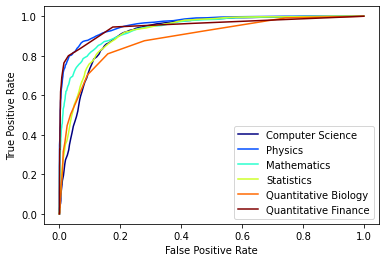

In [35]:
###########
# ROC & AUC 
###########

rfc = RandomForestClassifier(**rfc_gd_sr.best_params_)
#rfc = RandomForestClassifier(random_state=0, class_weight='balanced', verbose=1, n_estimators=100, criterion='entropy', bootstrap=True)
rfc.fit(X=X, y=Y)
Yv_p = rfc.predict_proba(Xv)
category_auc_rfc = []
Yv_category_prob = pd.DataFrame()
i=0
for i in range(Yv.shape[1]):
    print(i)
    Yv_category_prob[Yv.columns[i]] = copy.deepcopy(Yv_p[i][:,1])
    fpr, tpr, p_cutoff = metrics.roc_curve(Yv.iloc[:,i], Yv_p[i][:,1])
    category_auc_rfc.append(roc_auc_score(Yv.iloc[:,i], Yv_p[i][:,1]))
    plt.plot(fpr, tpr, color=colormap[i], label = Yv.columns[i]) 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

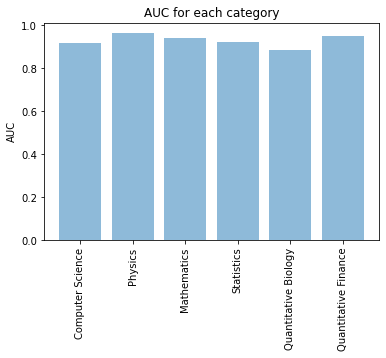

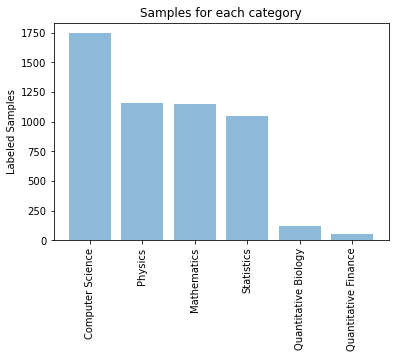

In [36]:
plt.bar(np.arange(len(Yv.columns)), category_auc_rfc, align='center', alpha=0.5)
plt.xticks(np.arange(len(Yv.columns)), Yv.columns)
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUC for each category')
plt.show()

plt.bar(np.arange(len(Yv.columns)), Yv.sum(axis=0), align='center', alpha=0.5)
plt.xticks(np.arange(len(Yv.columns)), Yv.columns)
plt.xticks(rotation=90)
plt.ylabel('Labeled Samples')
plt.title('Samples for each category')
plt.show()

In [37]:
# Print feature importances
rfc_feature_imp = pd.DataFrame({'Feature': X.columns.values, 'Importance':rfc.feature_importances_}).sort_values('Importance', ascending = False)
print(rfc_feature_imp.head(20))

         Feature  Importance
46       network    0.012917
461     learning    0.011876
448    algorithm    0.011636
110      propose    0.011263
211        prove    0.010468
102        paper    0.010180
10         model    0.009346
27         datum    0.009078
529        learn    0.007935
65   temperature    0.007714
341      problem    0.007417
786       energy    0.007251
69           use    0.007136
117         task    0.006838
148         base    0.006449
463  performance    0.006374
45        method    0.005493
73      approach    0.005317
7           find    0.005241
8           give    0.005064


# Topic Modeling

n:2 i:0
n:2 i:1
n:2 i:2
n:2 i:3
n:2 i:4
n:3 i:0
n:3 i:1
n:3 i:2
n:3 i:3
n:3 i:4
n:4 i:0
n:4 i:1
n:4 i:2
n:4 i:3
n:4 i:4
n:5 i:0
n:5 i:1
n:5 i:2
n:5 i:3
n:5 i:4
n:6 i:0
n:6 i:1
n:6 i:2
n:6 i:3
n:6 i:4
n:7 i:0
n:7 i:1
n:7 i:2
n:7 i:3
n:7 i:4
n:8 i:0
n:8 i:1
n:8 i:2
n:8 i:3
n:8 i:4
n:9 i:0
n:9 i:1
n:9 i:2
n:9 i:3
n:9 i:4


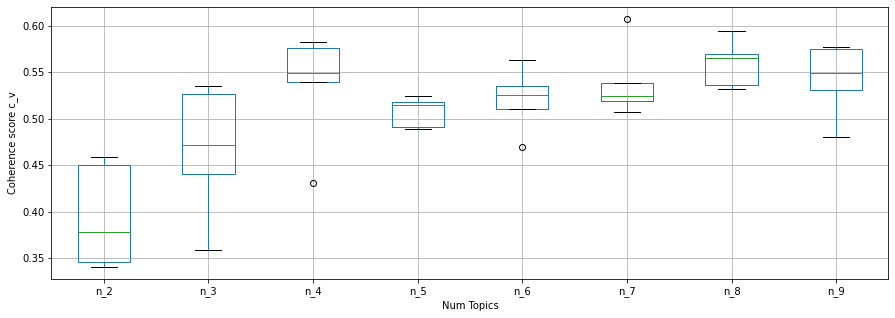

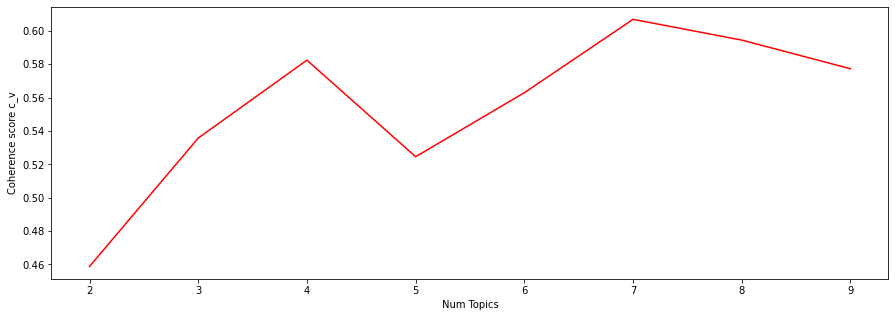

In [38]:
#################################
# Topic quality - coherence
#################################

corpus = corpus_tfidf_train
docs = docs_train
id2word = id2word

# https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
warnings.filterwarnings("ignore",category=DeprecationWarning)

start=2; limit=10;  step=1;
models_per_level = 5
c_v    = []
model_list = []
random_seed_list = []
df_c_v = pd.DataFrame()
model_list_i = 0
model_list_index = []

#num_topics=4
for num_topics in range(start, limit, step):
    c = -float("inf")
    i_max = 0
    c_list = []
    i=0
    for i in range(models_per_level):
        print('n:'+str(num_topics)+' i:'+str(i))
        model_i = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics,alpha='auto',per_word_topics=False, minimum_probability=0, random_state=i)
        c_i = CoherenceModel(model=model_i, texts=docs, dictionary=id2word, coherence='c_v' , processes =1).get_coherence()
        c_list.append(c_i)
        if c_i>c:
            model = copy.deepcopy(model_i)
            c = c_i
            i_max = i
    c_v.append (c)
    model_list.append(model)
    model_list_index.append(model_list_i)
    model_list_i += 1
    random_seed_list.append(i_max)
    df_c_v["n_"+str(num_topics)] = c_list


plt.figure(figsize=(15,5))
df_c_v.boxplot()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score c_v")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(range(start, limit, step), c_v,'r')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score c_v")
plt.show()


In [48]:
for i in range(0, len(model_list), 1):
    print("i:{0}, cv:{1}".format(i,c_v[i]))

# chose number of categories based on lowest coherence score
len(model_list)
i=5
c_v[i]
model = model_list[i]

i:0, cv:0.4587932262804999
i:1, cv:0.5357716935933755
i:2, cv:0.582464520529471
i:3, cv:0.5245753114378401
i:4, cv:0.5629461336786737
i:5, cv:0.6069394666727462
i:6, cv:0.5945051207743876
i:7, cv:0.5773261945827556


## LDA Viz

In [49]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
warnings.filterwarnings("ignore",category=DeprecationWarning)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, id2word, sort_topics=False)

In [50]:
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_vis_'+str(model.num_topics)+'_topics.html')

In [51]:
vis0 = vis[0] # topic	x	y	topics	cluster	Freq
vis1 = vis[1] # term	Category	Freq	Term	Total	loglift	logprob
vis2 = vis[2] # Topic, Freq, Term

## Word Cloud

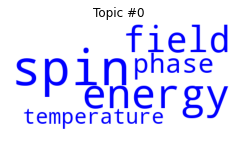

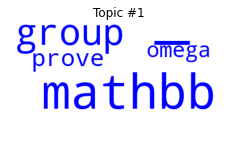

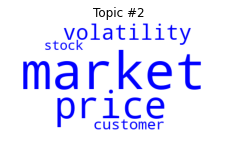

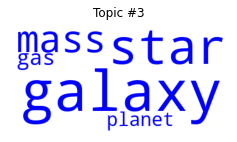

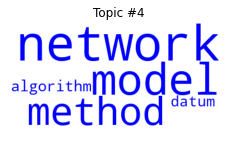

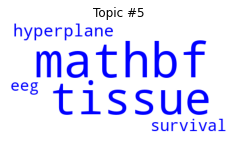

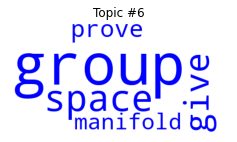

In [52]:
#https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud.fit_words
from wordcloud import WordCloud
w = WordCloud(background_color='white', relative_scaling=1, colormap ='tab10')
w = WordCloud(background_color='white', relative_scaling=1, color_func=lambda *args, **kwargs: (0,0,255))
for t in range(model.num_topics):
    plt.figure(figsize=(4,4))
    plt.imshow(w.fit_words(dict(model.show_topic(t, 5)) ))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

## Print Topics

In [53]:
model.print_topics()
from itertools import compress
warnings.filterwarnings("ignore",category=DeprecationWarning)

topic_key_words = []
max_key_works = 7
for t in range(model.num_topics):
    ss = [s for s, v in model.show_topic(t, max_key_works) if s!='pron']
    vv = [v for s, v in model.show_topic(t, max_key_works) if s!='pron']
    cum_percentile = np.cumsum(vv)/sum(vv)
    key_words = ss[0]
    for i in list(range(1,len(ss),1)):
        if cum_percentile[i]<0.8:
            key_words = key_words + ' ' + ss[i]
#    topic_key_words.append(' '.join([s for s, v in model.show_topic(t, 5) if s!='pron'] ))
    topic_key_words.append(key_words)
pprint(topic_key_words)


['spin energy field phase temperature',
 '_ mathbb group prove',
 'market price volatility customer',
 'galaxy star mass gas planet',
 'network model method algorithm datum',
 'mathbf tissue hyperplane survival eeg',
 'group space give prove manifold']


In [54]:
corpus_topics_df = pd.DataFrame(columns = topic_key_words)
for i, doc_topics in enumerate(list(model[corpus])):
    corpus_topics_df.loc[i] = np.round([p for t,p in doc_topics],2)

corpus_dominant_topic_df = pd.DataFrame({'Dominant Topic':corpus_topics_df.idxmax(axis=1), \
                                         'Dominant Topic Percent':corpus_topics_df.max(axis=1)})

## Vizualize Topic Clusers using TSNE and UMAP

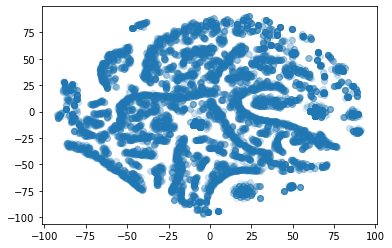

In [55]:
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore",category=DeprecationWarning)

topic_tsne_2d = TSNE(n_components=2, random_state=0).fit_transform(corpus_topics_df)
topic_tsne_2d_df = pd.DataFrame(data = topic_tsne_2d, columns = ['tsne_x','tsne_y'])
plt.scatter(topic_tsne_2d[:,0], topic_tsne_2d[:,1], alpha=0.1)
plt.show()

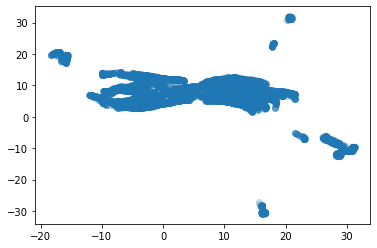

In [56]:
# https://stackoverflow.com/questions/57242208/how-to-resolve-the-error-module-umap-has-no-attribute-umap-i-tried-installi
#import umap
import umap.umap_ as umap
import matplotlib.cm as cm
warnings.filterwarnings("ignore",category=DeprecationWarning)

umap_n = max(round(corpus_topics_df.shape[0]*0.01),5)
topic_umap_2d = umap.UMAP(n_neighbors=umap_n, min_dist=0.3, n_components=2).fit_transform(corpus_topics_df.values)
topic_umap_2d_df = pd.DataFrame(data = topic_umap_2d, columns = ['umap_x','umap_y'])
plt.scatter(topic_umap_2d[:,0], topic_umap_2d[:,1], alpha=0.1)
plt.show()

# Save workspace

In [57]:
import dill
filename = 'All_Steps.pkl'
dill.dump_session(filename)
# and to load the session again:
#dill.load_session(filename)